## simple single point coronavirus predictions
#### using jhu covid data

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

loading data

In [27]:
datapath = "../COVID-19/csse_covid_19_data/csse_covid_19_time_series/"

# Choose from "US Cases", "US Deaths", "World Cases", "World Deaths", "World Recoveries"
key = "World Cases" 

if key == "US Cases":
    datapath = datapath + "time_series_covid19_confirmed_US.csv"
elif key == "US Deaths":
    datapath = datapath + "time_series_covid19_deaths_US.csv"
elif key == "World Cases":
    datapath = datapath + "time_series_covid19_confirmed_global.csv"
elif key == "World Deaths":
    datapath = datapath + "time_series_covid19_deaths_global.csv"
elif key == "World Recoveries":
    datapath = datapath + "time_series_covid19_recovered_global.csv"

In [28]:
covid_df = pd.read_csv(datapath)

In [29]:
covid_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,764,765,844,851,852,852,852,852,852,852
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,86,86,86,86,86,86,88,91,92,96


In [30]:
abridged_covid_df = covid_df.loc[:,'1/22/20':]

In [31]:
abridged_covid_df.index

RangeIndex(start=0, stop=266, step=1)

In [32]:
abridged_covid_df.index = covid_df['Country/Region']

In [33]:
abridged_covid_df

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459
Albania,0,0,0,0,0,0,0,0,0,0,...,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299
Algeria,0,0,0,0,0,0,0,0,0,0,...,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382
Andorra,0,0,0,0,0,0,0,0,0,0,...,764,765,844,851,852,852,852,852,852,852
Angola,0,0,0,0,0,0,0,0,0,0,...,86,86,86,86,86,86,88,91,92,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sao Tome and Principe,0,0,0,0,0,0,0,0,0,0,...,483,484,484,484,485,499,499,513,513,514
Yemen,0,0,0,0,0,0,0,0,0,0,...,323,354,399,419,453,469,482,484,496,524
Comoros,0,0,0,0,0,0,0,0,0,0,...,106,106,132,132,132,132,141,141,141,141


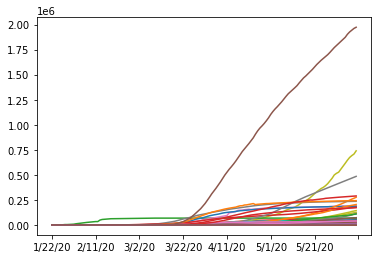

In [34]:
abridged_covid_df.T.plot(legend=False)

In [35]:
flattened_df = abridged_covid_df.to_numpy().flatten()
covid_data = flattened_df
num_regions = abridged_covid_df.shape[0]; print(num_regions)
num_days = abridged_covid_df.shape[1]; print(num_days)

266
140


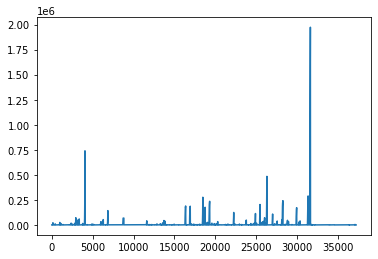

In [36]:
plt.plot(covid_data)

In [37]:
train_end_index = int(len(covid_data) * 0.8) ; train_end_index # about 70 percent for training

29792

In [38]:
# this code is directly from https://www.tensorflow.org/tutorials/structured_data/time_series

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
    
  return np.array(data), np.array(labels)

In [39]:
# time to scale these features and standardize using training data

train_data_mean = covid_data[:train_end_index].mean()
train_data_std = covid_data[:train_end_index].std()
print(train_data_mean, train_data_std)
covid_data = (covid_data - train_data_mean)/train_data_std

5779.865668635875 28489.072641901068


In [40]:
# choose {trig_past_history} vals to use to predict {trig_future_target + 1} vals into the future
covid_past_history = 20
covid_future_target = 0

x_train_trig, y_train_trig = univariate_data(covid_data, 0, train_end_index, covid_past_history, covid_future_target)

x_val_trig, y_val_trig = univariate_data(covid_data, train_end_index, None, covid_past_history, covid_future_target)

In [41]:
print(x_train_trig.shape, y_train_trig.shape)
print(x_train_trig.shape[-2:])

(29772, 20, 1) (29772,)
(20, 1)


In [42]:
print(x_val_trig.shape, y_val_trig.shape)

(7428, 20, 1) (7428,)


Past history example:
 [[-0.16602386]
 [-0.16511122]
 [-0.1643039 ]
 [-0.16349657]
 [-0.16297005]
 [-0.16275945]
 [-0.16202232]
 [-0.1613203 ]
 [-0.16086398]
 [-0.16033746]
 [-0.15963544]
 [-0.15914402]
 [-0.1585473 ]
 [-0.15728366]
 [-0.20288009]
 [-0.20288009]
 [-0.20288009]
 [-0.20288009]
 [-0.20288009]
 [-0.20288009]]
using this history to predict the val:  -0.20288009165082416


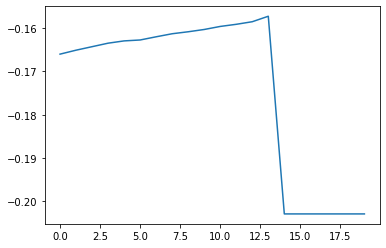

In [43]:
index = 266
print("Past history example:\n", x_train_trig[index])
print("using this history to predict the val: ", y_train_trig[index])
plt.plot(x_train_trig[index])

In [44]:
# much of below code is derived from https://www.tensorflow.org/tutorials/structured_data/time_series

BATCH_SIZE = num_days
BUFFER_SIZE = num_days * 10

train_trig = tf.data.Dataset.from_tensor_slices((x_train_trig, y_train_trig))
train_trig = train_trig.cache().batch(BATCH_SIZE).repeat()

val_trig = tf.data.Dataset.from_tensor_slices((x_val_trig, y_val_trig))
val_trig = val_trig.batch(BATCH_SIZE).repeat()

In [45]:
# creating the neural network model

lstm_prediction_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_trig.shape[-2:]),
    tf.keras.layers.Dense(1)
])

In [46]:
lstm_prediction_model.compile(optimizer='adam', loss='mae')

In [47]:
lstm_prediction_model.fit(train_trig, epochs=20, steps_per_epoch=150, validation_data=val_trig, validation_steps=50)

Train for 150 steps, validate for 50 steps
Epoch 1/20
150/150 [==============================] - 7s 49ms/step - loss: 0.2148 - val_loss: 0.5245
Epoch 2/20
150/150 [==============================] - 5s 30ms/step - loss: 0.1513 - val_loss: 0.5109
Epoch 3/20
150/150 [==============================] - 4s 30ms/step - loss: 0.1678 - val_loss: 0.4984
Epoch 4/20
150/150 [==============================] - 4s 30ms/step - loss: 0.1146 - val_loss: 0.4872
Epoch 5/20
150/150 [==============================] - 5s 31ms/step - loss: 0.0936 - val_loss: 0.4770
Epoch 6/20
150/150 [==============================] - 5s 31ms/step - loss: 0.1395 - val_loss: 0.4687
Epoch 7/20
150/150 [==============================] - 5s 31ms/step - loss: 0.0917 - val_loss: 0.4616
Epoch 8/20
150/150 [==============================] - 5s 31ms/step - loss: 0.0790 - val_loss: 0.4567
Epoch 9/20
150/150 [==============================] - 5s 32ms/step - loss: 0.0840 - val_loss: 0.4475
Epoch 10/20
150/150 [===========================

In [48]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

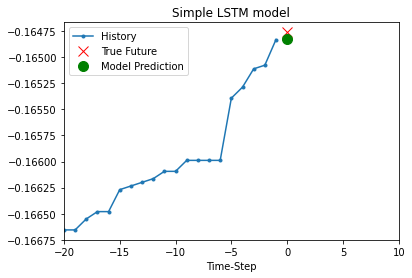

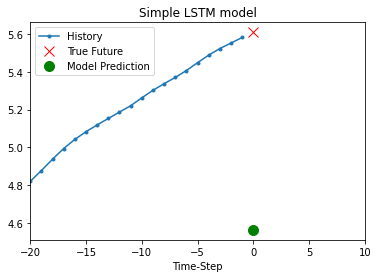

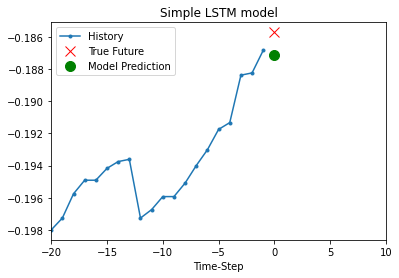

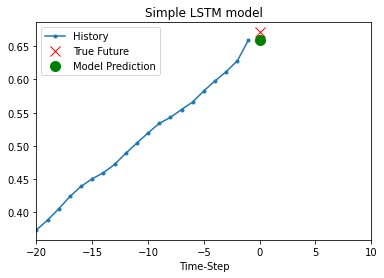

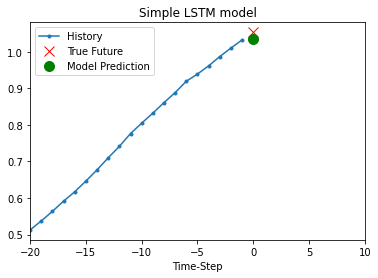

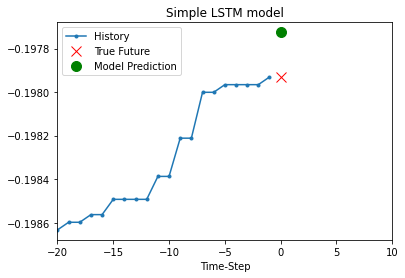

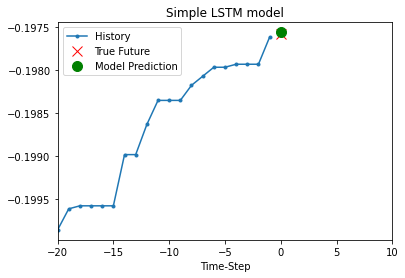

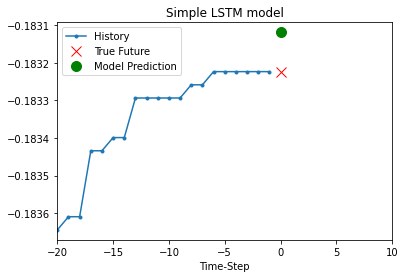

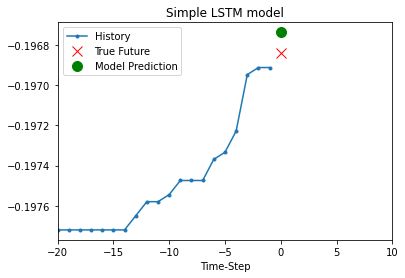

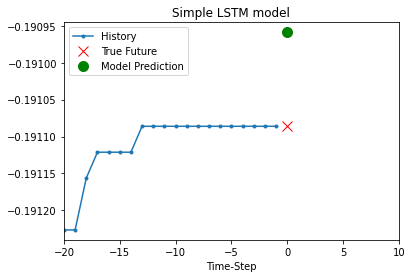

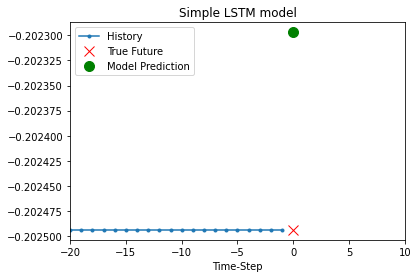

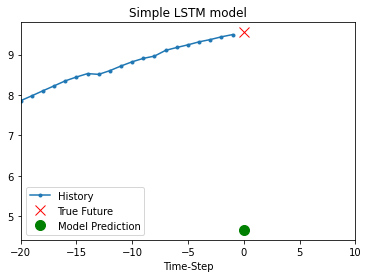

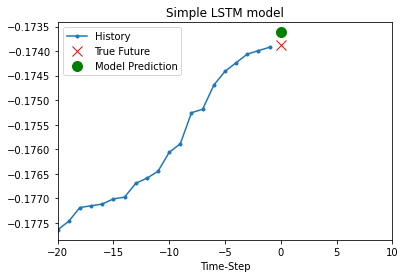

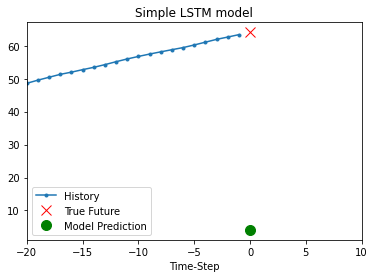

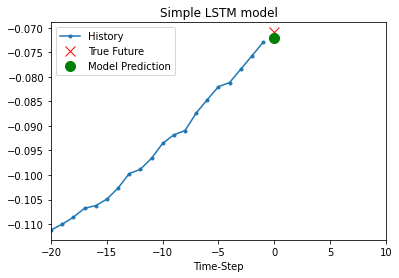

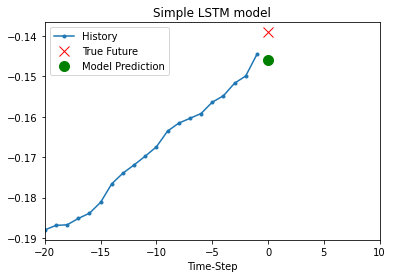

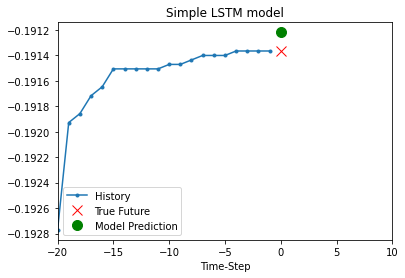

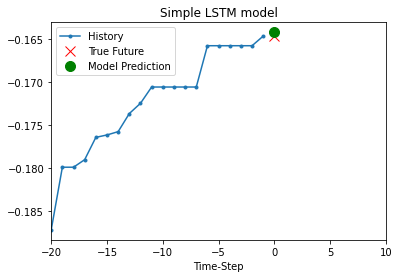

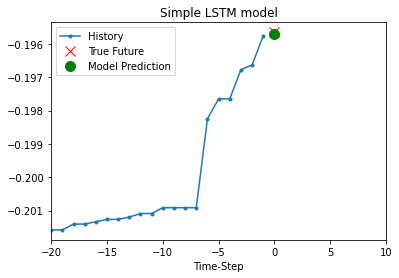

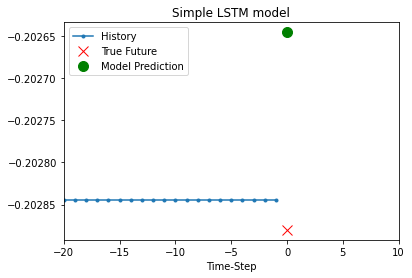

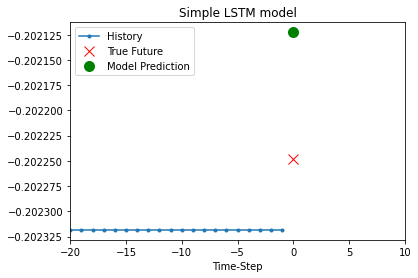

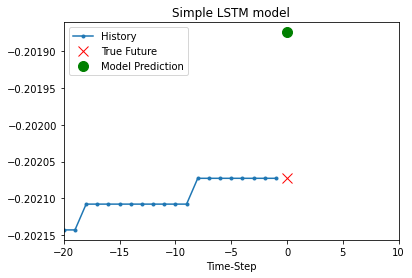

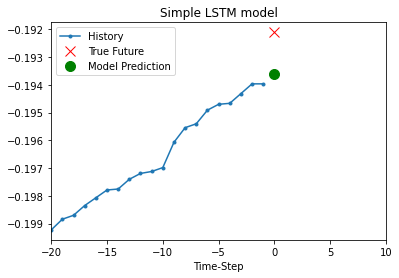

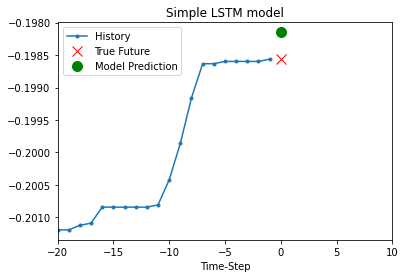

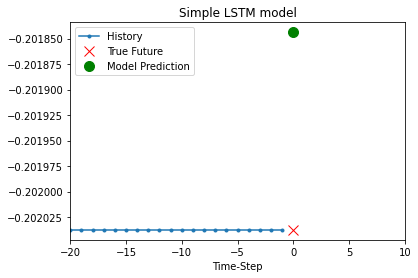

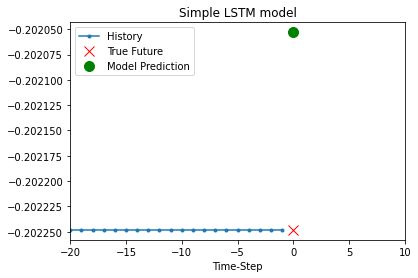

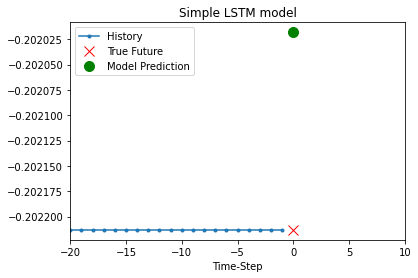

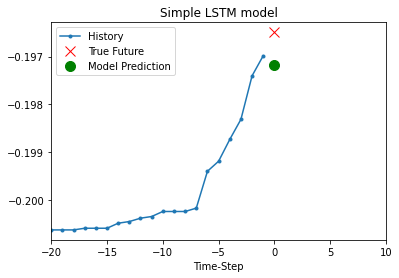

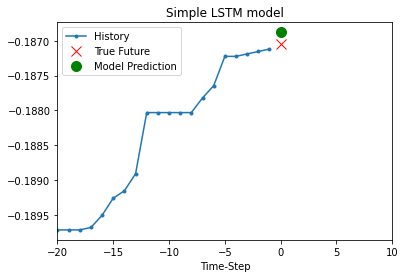

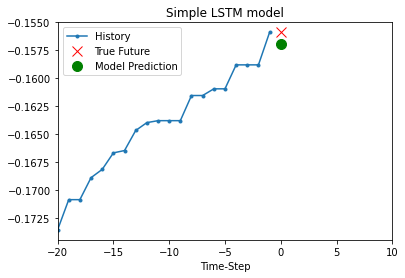

In [49]:
for x, y in val_trig.take(30):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    lstm_prediction_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()